### Time Series Forecasting using LSTM

In [1]:
# Importing libraries
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import os

mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['axes.grid'] = False



In [2]:
orig_df = pd.read_csv('/Users/faymajidelhassan/Downloads/Master project /Data/Weather/measurements/Combinedweather_measurements10T.csv') 
df = orig_df.copy() 
print(f'Size of the dataset: {df.shape} \n')  
print() 
display(df.head(5))

Size of the dataset: (256352, 9) 




,timestamp,temperature,humidity,pressure,global_irradiance,direct_irradiance,diffuse_irradiance,precipitation,duration
0,2018-04-17 05:20:00,14.10,78.666667,9956.666667,54.0,0.0,54.0,NaN,NaN
1,2018-04-17 05:30:00,14.16,78.100000,9958.400000,178.0,0.0,178.0,NaN,NaN
2,2018-04-17 05:40:00,14.32,78.000000,9959.800000,322.0,0.0,321.0,NaN,NaN
3,2018-04-17 05:50:00,14.49,78.600000,9960.900000,560.0,0.0,560.0,NaN,NaN
4,2018-04-17 06:00:00,14.66,78.100000,9963.000000,643.0,0.0,645.0,0.1,5.0


In [3]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)
# df = df.resample('10T').agg({
#     'temperature': 'mean',  # Average temperature for the hour
#     'humidity': 'mean',     # Average humidity for the hour
#     'pressure': 'mean',     # Average pressure for the hour
#     'global_irradiance': 'sum',  # Total irradiance may be summed
#     'direct_irradiance': 'sum',
#     'diffuse_irradiance': 'sum'
#     # 'precipitation': 'sum'
# })

In [ ]:
# df2=pd.read_csv('/Users/faymajidelhassan/Downloads/Master project /Data/Weather/measurements/filtered_precipitation_measurements.csv')
# df2['timestamp'] = pd.to_datetime(df2['timestamp'])
# df2.set_index('timestamp',inplace=True)
# df2=df2.resample('10T').agg({'precipitation': 'sum','duration':'sum'})
# df2.head()

In [ ]:
# result = df.join(df2, how='left')

In [ ]:
# print(result.head())

In [ ]:
# result.to_csv('/Users/faymajidelhassan/Downloads/Master project /Data/Weather/measurements/Combinedweather_measurements10T.csv')
# print(result.head())

In [ ]:
# df=result

In [4]:
df.isnull().sum()
# df=df.fillna(df.mean())

temperature               0
humidity                  0
pressure                  0
global_irradiance         0
direct_irradiance         0
diffuse_irradiance        0
precipitation         61369
duration              61369
dtype: int64

In [5]:
# df=df.fillna(df.mean())
df = df.apply(lambda col: col.fillna(col.mean()), axis=0)

df.isnull().sum()
df.head()

,temperature,humidity,pressure,global_irradiance,direct_irradiance,diffuse_irradiance,precipitation,duration
timestamp,,,,,,,,
2018-04-17 05:20:00,14.10,78.666667,9956.666667,54.0,0.0,54.0,0.014981,0.334029
2018-04-17 05:30:00,14.16,78.100000,9958.400000,178.0,0.0,178.0,0.014981,0.334029
2018-04-17 05:40:00,14.32,78.000000,9959.800000,322.0,0.0,321.0,0.014981,0.334029
2018-04-17 05:50:00,14.49,78.600000,9960.900000,560.0,0.0,560.0,0.014981,0.334029
2018-04-17 06:00:00,14.66,78.100000,9963.000000,643.0,0.0,645.0,0.100000,5.000000


Observations:
1) One reading evrry 10 mins (from datatime column time diff for every record )
2) 1day = 6*24 = 144 readings
Task : Forecasting Temperature(in degree ) in future 




In [6]:
## using univariate feature(Only temperature for given time)

uni_data = df['temperature']
# uni_data.index = df['timestamp']
uni_data.head()

timestamp
2018-04-17 05:20:00    14.10
2018-04-17 05:30:00    14.16
2018-04-17 05:40:00    14.32
2018-04-17 05:50:00    14.49
2018-04-17 06:00:00    14.66
Name: temperature, dtype: float64

<Axes: xlabel='timestamp'>

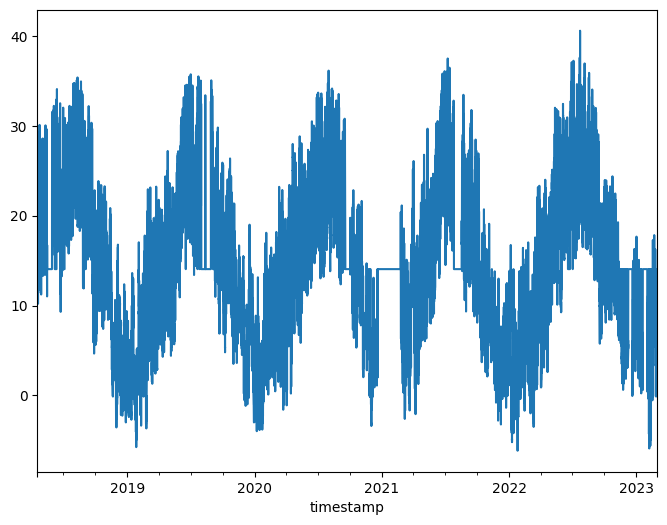

In [7]:
uni_data.plot()

In [8]:
uni_data = uni_data.values

In [9]:
uni_data.shape

(256352,)

In [10]:
## train test split for simple time series moving window average
train_split = int(len(uni_data) * 0.8)#205082 #43228
tf.random.set_seed(13)

### standardize data
uni_data_mean = uni_data[:train_split].mean()
uni_data_std = uni_data[:train_split].std()
uni_data  = (uni_data - uni_data_mean)/ uni_data_std

print(type(uni_data))


<class 'numpy.ndarray'>


Moving Window Average


1.   Given last 20 values of observations(temp) , predict next observation
2.   MWA: predict== AVG(last 20 values)




In [11]:
## utility functions

## funtion to create data for univariate forecasting

def univariate_data(dataset, start_idx , end_idx , history_size, target_size):
  data = []
  labels = []
  start_idx  = start_idx + history_size
  if end_idx is None:
    end_idx = len(dataset)- target_size
  for i in range(start_idx , end_idx):
    idxs = range(i-history_size , i)
    data.append(np.reshape(dataset[idxs] , (history_size, 1))) ### reshape data
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

uni_data_history = 20   ## last 50 values
uni_data_future = 0     ## future data

x_train_uni , y_train_uni = univariate_data(uni_data , 0 , train_split , uni_data_history , uni_data_future)

x_val_uni , y_val_uni = univariate_data(uni_data , train_split , None ,uni_data_history , uni_data_future)

In [12]:
x_train_uni

array([[[ 0.04605953],
        [ 0.05350872],
        [ 0.07337323],
        ...,
        [ 0.06219944],
        [ 0.07958088],
        [ 0.09696233]],

       [[ 0.05350872],
        [ 0.07337323],
        [ 0.09447927],
        ...,
        [ 0.07958088],
        [ 0.09696233],
        [ 0.15407279]],

       [[ 0.07337323],
        [ 0.09447927],
        [ 0.11558531],
        ...,
        [ 0.09696233],
        [ 0.15407279],
        [ 0.20249253]],

       ...,

       [[-2.02481554],
        [-2.01115869],
        [-2.00246797],
        ...,
        [-1.65359753],
        [-1.60393626],
        [-1.55675805]],

       [[-2.01115869],
        [-2.00246797],
        [-1.99377725],
        ...,
        [-1.60393626],
        [-1.55675805],
        [-1.55179192]],

       [[-2.00246797],
        [-1.99377725],
        [-1.98136193],
        ...,
        [-1.55675805],
        [-1.55179192],
        [-1.55427498]]])

In [13]:
print(x_train_uni.shape , y_train_uni.shape)
print(x_val_uni.shape , y_val_uni.shape)

(205061, 20, 1) (205061,)
(51251, 20, 1) (51251,)


In [14]:
print('Single window of history data' , x_train_uni[0])

print('Target Temperature to predict ' , y_train_uni[0])


Single window of history data [[ 0.04605953]
 [ 0.05350872]
 [ 0.07337323]
 [ 0.09447927]
 [ 0.11558531]
 [ 0.12427603]
 [ 0.13917441]
 [ 0.11806837]
 [ 0.06964863]
 [-0.00856787]
 [-0.0681614 ]
 [-0.06691987]
 [-0.0408477 ]
 [-0.01229247]
 [ 0.01253817]
 [ 0.02867808]
 [ 0.05102565]
 [ 0.06219944]
 [ 0.07958088]
 [ 0.09696233]]
Target Temperature to predict  0.15407279385741993


<module 'matplotlib.pyplot' from '/Users/faymajidelhassan/anaconda3/envs/m/lib/python3.10/site-packages/matplotlib/pyplot.py'>

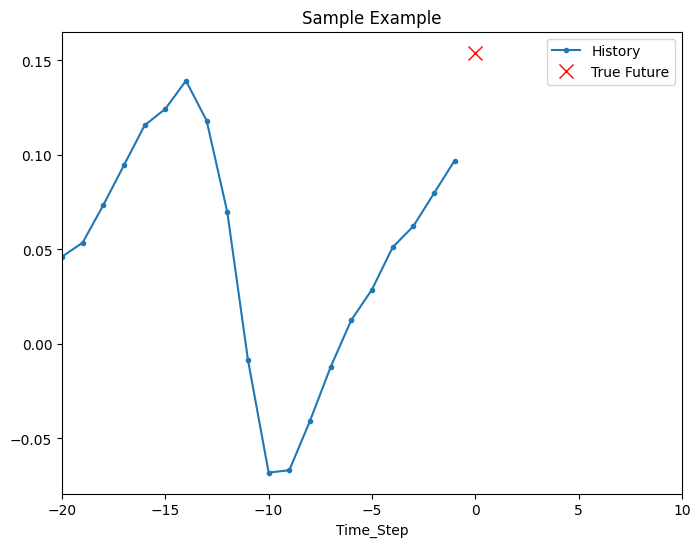

In [15]:
### fucntion to create time steps
def create_time_steps(length):
  return list(range(-length,0))

### function to plot time series data

def plot_time_series(plot_data, delta , title):
  labels = ["History" , 'True Future' , 'Model Predcited']
  marker = ['.-' , 'rx' , 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])

  if delta:
    future = delta
  else:
    future = 0
  plt.title(title)
  for i , x in enumerate(plot_data):
    if i :
      plt.plot(future , plot_data[i] , marker[i], markersize = 10 , label = labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label = labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5) *2])

  plt.xlabel('Time_Step')
  return plt

plot_time_series([x_train_uni[0] , y_train_uni[0]] , 0 , 'Sample Example')

<module 'matplotlib.pyplot' from '/Users/faymajidelhassan/anaconda3/envs/m/lib/python3.10/site-packages/matplotlib/pyplot.py'>

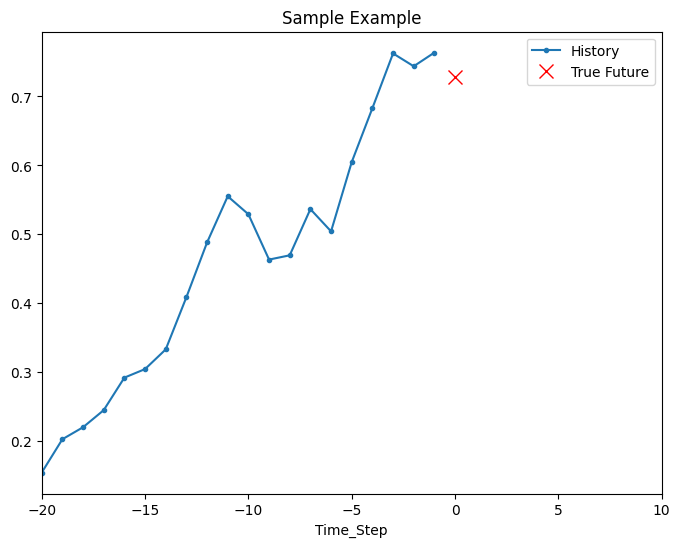

In [16]:
i = 20
plot_time_series([x_train_uni[i], y_train_uni[i]] , 0 , 'Sample Example')

In [17]:
### Moving window average

def MWA(history):
  return np.mean(history)




<module 'matplotlib.pyplot' from '/Users/faymajidelhassan/anaconda3/envs/m/lib/python3.10/site-packages/matplotlib/pyplot.py'>

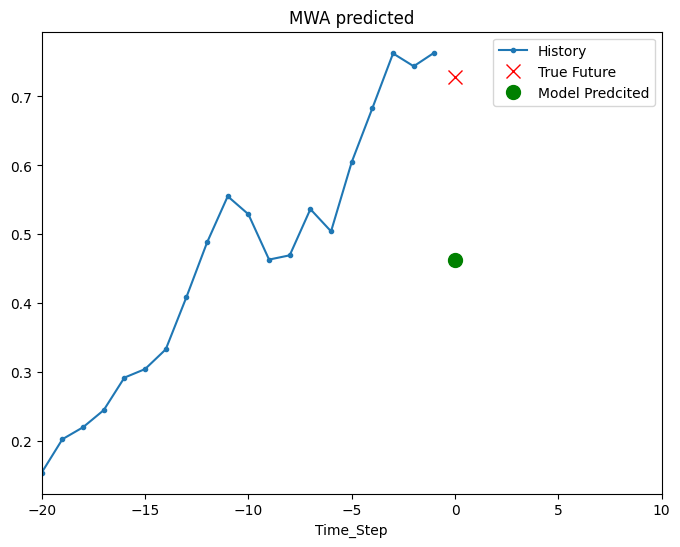

In [18]:
i = 20
plot_time_series([x_train_uni[i] , y_train_uni[i] , MWA(x_train_uni[i])] , 0 , 'MWA predicted')

Univariate time-series forecasting


*   Only single feature as temperature(historical data)
*   Task:  Given last 20 observations(history) , predict next temperature value 



In [19]:
## prepare tensorflow dataset
batch_size = 256
buffer_size = 10000

train_uni = tf.data.Dataset.from_tensor_slices((x_train_uni , y_train_uni))
train_uni = train_uni.cache().shuffle(buffer_size).batch(batch_size).repeat()

val_uni = tf.data.Dataset.from_tensor_slices((x_val_uni , y_val_uni))
val_uni = val_uni.cache().shuffle(buffer_size).batch(batch_size).repeat()

print(train_uni)
print(val_uni)

<_RepeatDataset element_spec=(TensorSpec(shape=(None, 20, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>
<_RepeatDataset element_spec=(TensorSpec(shape=(None, 20, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>


In [20]:
## Define LSTM model 

lstm_model = tf.keras.models.Sequential([tf.keras.layers.LSTM(16 , input_shape = x_train_uni.shape[-2:]), 
                                         tf.keras.layers.Dense(1)])

lstm_model.compile(optimizer = 'adam', loss = 'mae')

steps = 200

EPOCHS =10

lstm_model.fit(train_uni , epochs = EPOCHS, steps_per_epoch = steps ,
               validation_data = val_uni, validation_steps = 50)




Epoch 1/10


/Users/faymajidelhassan/anaconda3/envs/m/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.3750 - val_loss: 0.0735
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0543 - val_loss: 0.0557
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0432 - val_loss: 0.0369
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0372 - val_loss: 0.0343
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0348 - val_loss: 0.0368
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0319 - val_loss: 0.0344
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0298 - val_loss: 0.0260
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0256 - val_loss: 0.0242
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0247 - val_loss: 0.0266
Epoch 10/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0237 - val_loss: 0.0256


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


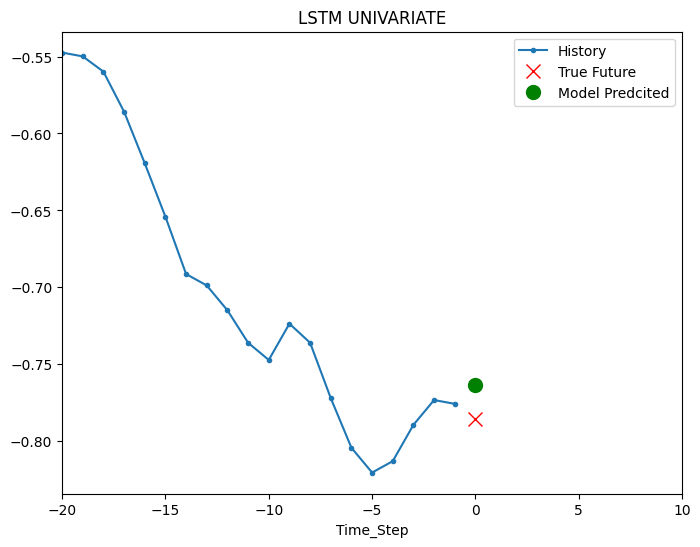

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


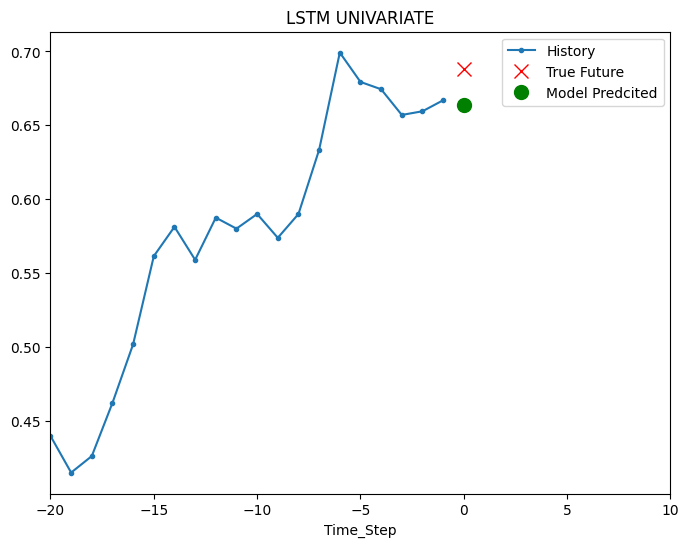

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


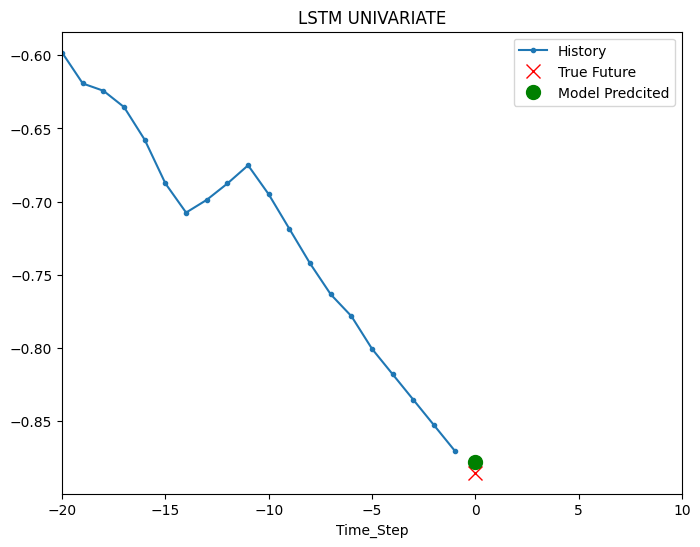

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


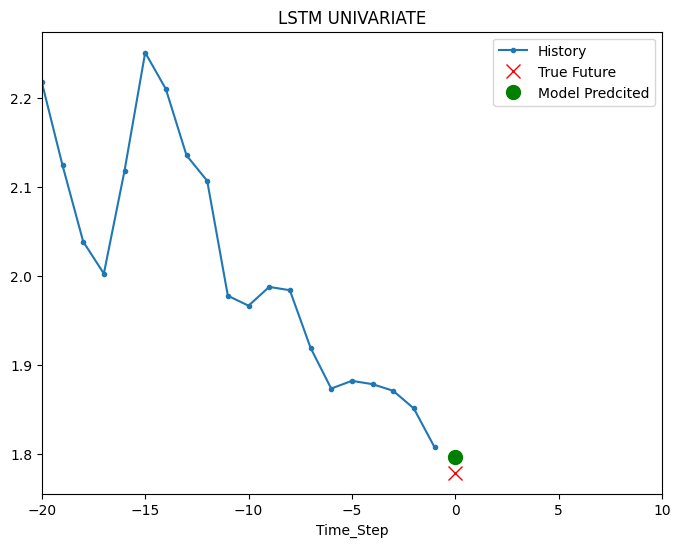

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


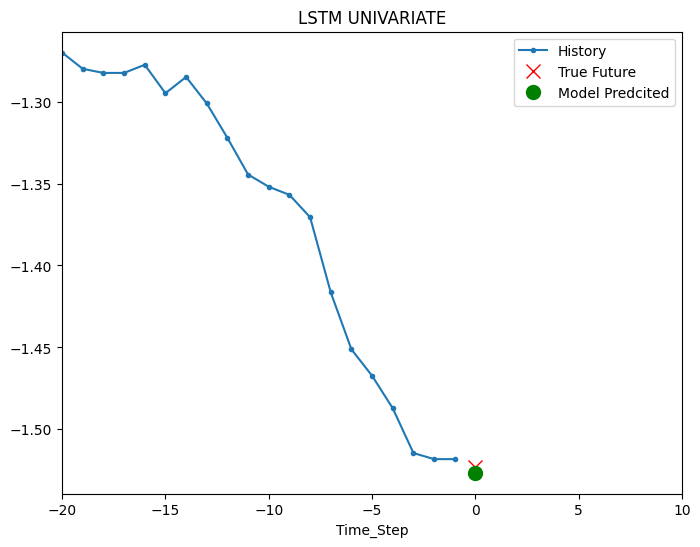

2024-06-03 09:13:17.078487: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [21]:
for i , j in val_uni.take(5):
  plot = plot_time_series([i[0].numpy() , j[0].numpy() , lstm_model.predict(i)[0]] ,0 , 'LSTM UNIVARIATE')
  plot.show()

Multivariate  and Single step Forecasting


*   Task: Given 3 features(temp , pressure , and density) at each time step can we predict the temp in future at single time step




In [22]:
## features 

features_6 = ['temperature', 'humidity', 'pressure', 'global_irradiance', 'direct_irradiance', 'diffuse_irradiance','precipitation']

features = df[features_6]
# features.index = df['timestamp']
features.head()



,temperature,humidity,pressure,global_irradiance,direct_irradiance,diffuse_irradiance,precipitation
timestamp,,,,,,,
2018-04-17 05:20:00,14.10,78.666667,9956.666667,54.0,0.0,54.0,0.014981
2018-04-17 05:30:00,14.16,78.100000,9958.400000,178.0,0.0,178.0,0.014981
2018-04-17 05:40:00,14.32,78.000000,9959.800000,322.0,0.0,321.0,0.014981
2018-04-17 05:50:00,14.49,78.600000,9960.900000,560.0,0.0,560.0,0.014981
2018-04-17 06:00:00,14.66,78.100000,9963.000000,643.0,0.0,645.0,0.100000


In [23]:
features.isnull().sum()

temperature           0
humidity              0
pressure              0
global_irradiance     0
direct_irradiance     0
diffuse_irradiance    0
precipitation         0
dtype: int64

array([<Axes: xlabel='timestamp'>, <Axes: xlabel='timestamp'>,
       <Axes: xlabel='timestamp'>, <Axes: xlabel='timestamp'>,
       <Axes: xlabel='timestamp'>, <Axes: xlabel='timestamp'>,
       <Axes: xlabel='timestamp'>], dtype=object)

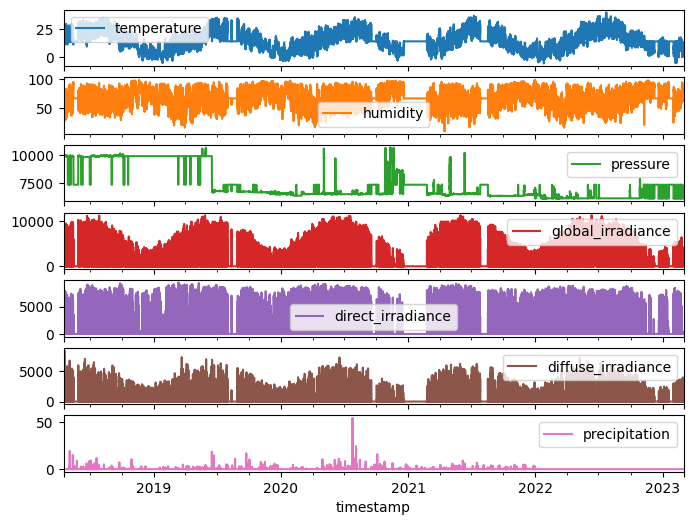

In [24]:
features.plot(subplots=True)

In [25]:
### standardize data
dataset = features.values
# dataset = np.array(features)

data_mean = dataset[:train_split].mean(axis =0)

data_std = dataset[:train_split].std(axis = 0)

dataset = (dataset - data_mean)/data_std



In [26]:
### create mutlivariate data

def mutlivariate_data(dataset , target , start_idx , end_idx , history_size , target_size,
                      step ,  single_step = False):
  data = []
  labels = []
  start_idx = start_idx + history_size
  if end_idx is None:
    end_idx = len(dataset)- target_size
  for i in range(start_idx , end_idx ):
    idxs = range(i-history_size, i, step) ### using step
    data.append(dataset[idxs])
    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data) , np.array(labels)



In [27]:
# ### generate multivariate data

history = 720
future_target = 72
STEP = 6

x_train_ss , y_train_ss = mutlivariate_data(dataset , dataset[:, 1], 0, train_split, history,
                                            future_target, STEP , single_step = True)

x_val_ss , y_val_ss = mutlivariate_data(dataset , dataset[:,1] , train_split , None , history ,
                                        future_target, STEP, single_step = True)



print(x_train_ss.shape, y_train_ss.shape)
print(x_val_ss.shape, y_val_ss.shape)


(204361, 120, 7) (204361,)
(50479, 120, 7) (50479,)


In [28]:
## tensorflow dataset

train_ss = tf.data.Dataset.from_tensor_slices((x_train_ss, y_train_ss))
train_ss = train_ss.cache().shuffle(buffer_size).batch(batch_size).repeat()

val_ss = tf.data.Dataset.from_tensor_slices((x_val_ss, y_val_ss))
val_ss = val_ss.cache().shuffle(buffer_size).batch(batch_size).repeat()

print(train_ss)
print(val_ss)



<_RepeatDataset element_spec=(TensorSpec(shape=(None, 120, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>
<_RepeatDataset element_spec=(TensorSpec(shape=(None, 120, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>


In [29]:
### Modelling using LSTM
from tensorflow.keras import layers, models, optimizers, callbacks
# Cosine Learning Rate Schedule
initial_learning_rate = 0.001
decay_steps = 1000  # Number of steps after which learning rate is decayed
alpha = 0.0  # Minimum learning rate value as a fraction of the initial learning rate

cosine_decay = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=decay_steps,
    alpha=alpha
)
from keras.callbacks import EarlyStopping
callbacks = EarlyStopping(
    patience = 5 , 
    restore_best_weights = True , 
    monitor = 'val_loss'
)
# lstm_model = tf.keras.models.Sequential([tf.keras.layers.LSTM(16 , input_shape = x_train_uni.shape[-2:]), 
#                                          tf.keras.layers.Dense(1)])
single_step_model = tf.keras.models.Sequential()

single_step_model.add(tf.keras.layers.LSTM(32,input_shape = x_train_ss.shape[-2:]))
# single_step_model.add(layers.LayerNormalization())
# single_step_model.add(tf.keras.layers.LSTM(64,return_sequences=False))
# single_step_model.add(layers.LayerNormalization())/
# single_step_model.add(tf.keras.layers.Dense(2, activation="relu"))
single_step_model.add(tf.keras.layers.Dense(1))
single_step_model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mae')
single_step_model_history = single_step_model.fit(train_ss, epochs = EPOCHS ,
                                                  steps_per_epoch =steps,verbose=1, validation_data = val_ss,
                                                  validation_steps = 50,callbacks=[callbacks])


Epoch 1/10


/Users/faymajidelhassan/anaconda3/envs/m/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - loss: 0.4958 - val_loss: 0.7678
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step - loss: 0.4922 - val_loss: 0.5725
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step - loss: 0.4833 - val_loss: 0.5306
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - loss: 0.4562 - val_loss: 0.4212
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - loss: 0.4375 - val_loss: 0.5520
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 12s 58ms/step - loss: 0.4506 - val_loss: 0.5704
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - loss: 0.4631 - val_loss: 0.5064
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - loss: 0.4352 - val_loss: 0.4299
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - loss: 0.4296 - val_loss: 0.5513


In [39]:
directory = '/Users/faymajidelhassan/Downloads/Master project /CODE/EDA/Saved_models'
filename = 'Lstm_single_step_model_measure+precip.h5'
model_path = f'{directory}/{filename}'
single_step_model.save(model_path)

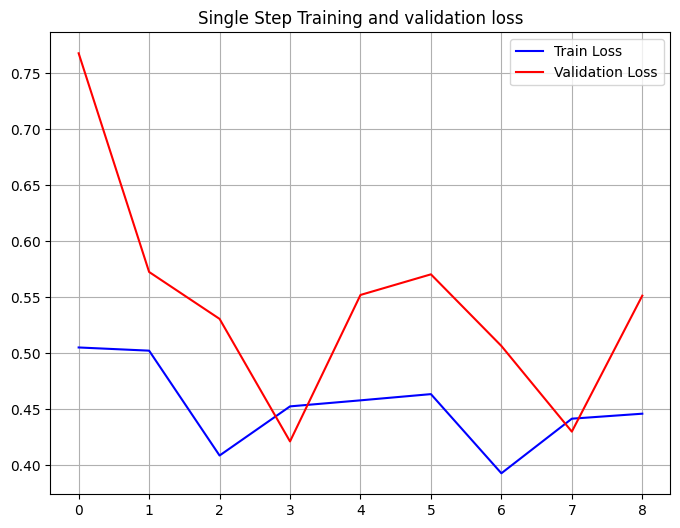

In [30]:
## plot train test loss 

def plot_loss(history , title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))
  plt.figure()
  plt.plot(epochs, loss , 'b' , label = 'Train Loss')
  plt.plot(epochs, val_loss , 'r' , label = 'Validation Loss')
  plt.title(title)
  plt.legend()
  plt.grid()
  plt.show()

plot_loss(single_step_model_history , 'Single Step Training and validation loss')

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  


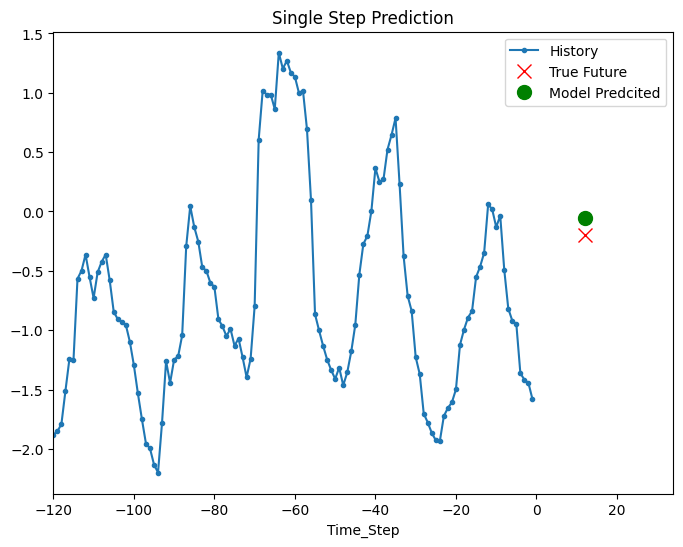

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


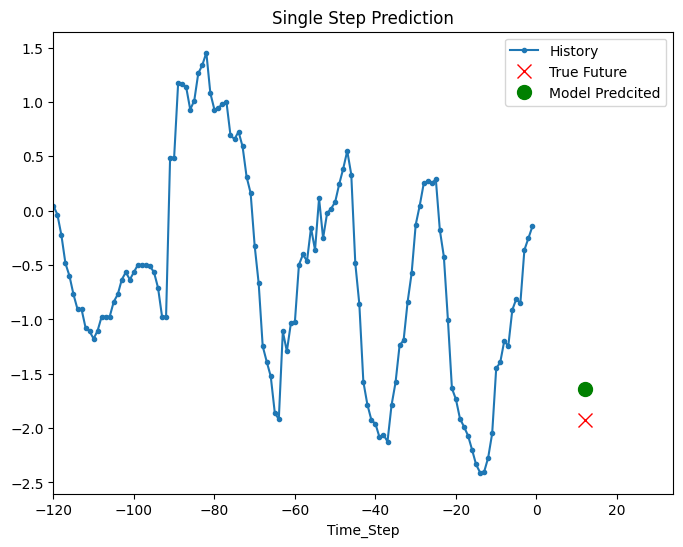

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


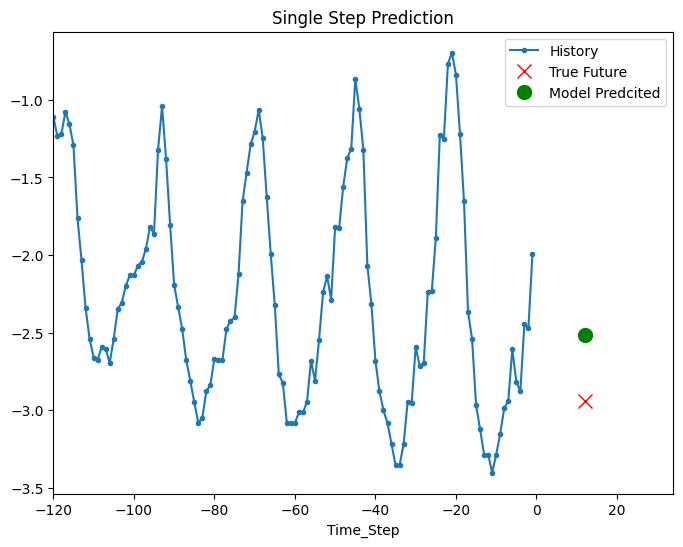

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


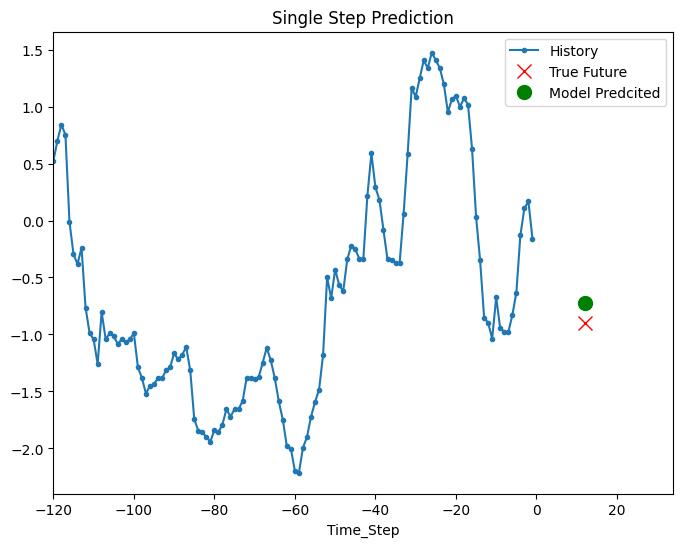

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


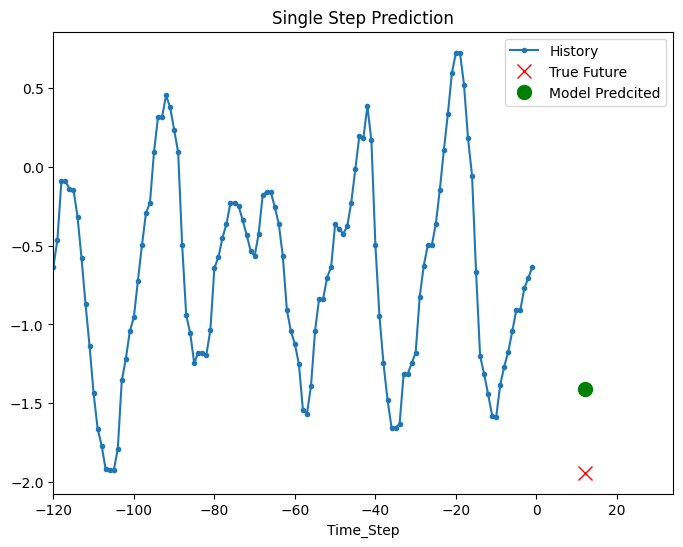

2024-06-03 09:16:36.826247: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [31]:
for x, y in val_ss.take(5):
  plot = plot_time_series([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Single Step Prediction')
  plot.show()

Multi-variate & multi-step forecasting
-> Generate multiple future values of temperature

In [32]:
future_target = 72 # 72 future values
x_train_multi, y_train_multi = mutlivariate_data(dataset, dataset[:, 1], 0,
                                                 train_split, history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = mutlivariate_data(dataset, dataset[:, 1],
                                             train_split, None, history,
                                             future_target, STEP)

print(x_train_multi.shape)
print(y_train_multi.shape)




(204361, 120, 7)
(204361, 72)


In [33]:
# TF DATASET

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(buffer_size).batch(batch_size).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(batch_size).repeat()

2024-06-03 09:16:57.960488: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


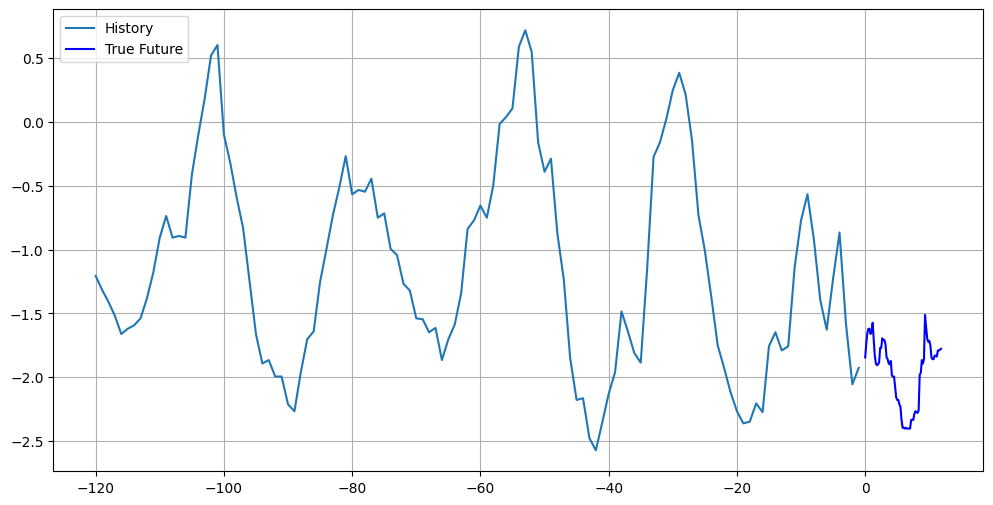

2024-06-03 09:16:58.120931: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [34]:
#plotting function
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)
  plt.grid()
  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'b-',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'r-',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()
  


for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

In [35]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
# multi_step_model.add(tf.keras.layers.LSTM(4,return_sequences=False, activation='relu'))
multi_step_model.add(tf.keras.layers.LSTM(16,activation='relu')) # for 72 output
multi_step_model.add(tf.keras.layers.Dense(72)) # for 72 outputs

multi_step_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=cosine_decay,clipvalue=1.0), loss='mae')
multi_step_model.summary()
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=steps,
                                          validation_data=val_data_multi,
                                          validation_steps=50,callbacks=[callbacks])





Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 120, 32)        │         5,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 72)             │         1,224 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,480 (37.03 KB)

 Trainable params: 9,480 (37.03 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 21s 87ms/step - loss: 0.5819 - val_loss: 0.9374
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 18s 92ms/step - loss: 0.4480 - val_loss: 0.4334
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 18s 88ms/step - loss: 0.3957 - val_loss: 0.4431
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 18s 89ms/step - loss: 0.3626 - val_loss: 0.2935
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 18s 91ms/step - loss: 0.3730 - val_loss: 0.4540
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 18s 91ms/step - loss: 0.3829 - val_loss: 0.4271
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 18s 91ms/step - loss: 0.3987 - val_loss: 0.4126
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 19s 94ms/step - loss: 0.3795 - val_loss: 0.3147
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 17s 84ms/step - loss: 0.3711 - val_loss: 0.4457


In [48]:


# Create a new model that outputs the features from the second LSTM layer
feature_extractor = tf.keras.Model(inputs=multi_step_model.input,
                                   outputs=multi_step_model.get_layer(index=0).output)  # LSTM layer at index 1

# Summary of the feature extractor model
feature_extractor.summary()

# Example data for which you want to extract features (replace with actual data)
x_val_example, y_val_example = next(iter(val_data_multi))  # Get a batch of validation data

# Extract LSTM features
lstm_features = feature_extractor.predict(x_val_example)

# Print the shape of the extracted features
print(f'LSTM features shape: {lstm_features.shape}')


ValueError: The layer sequential_2 has never been called and thus has no defined input.

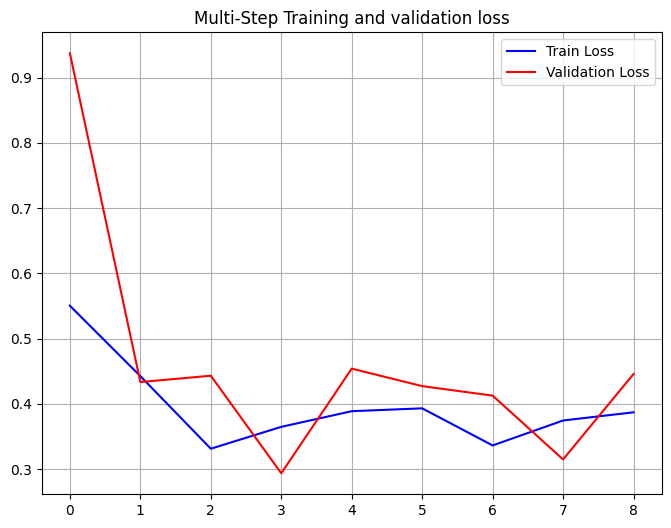

In [36]:
plot_loss(multi_step_history, 'Multi-Step Training and validation loss')


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


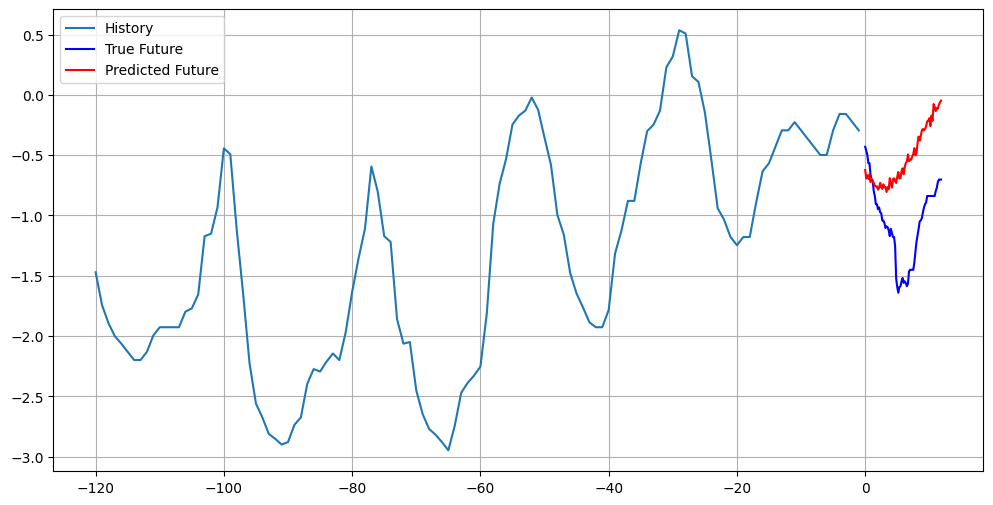

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


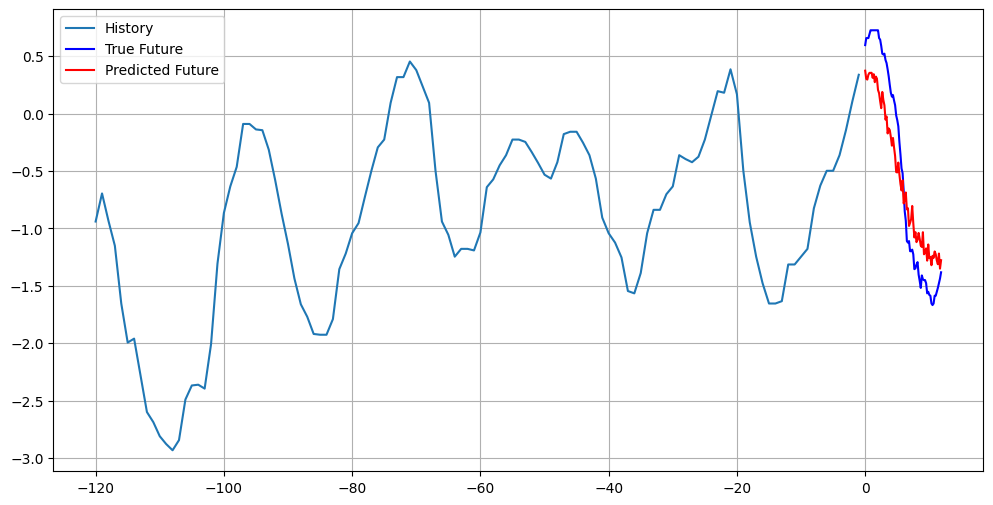

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


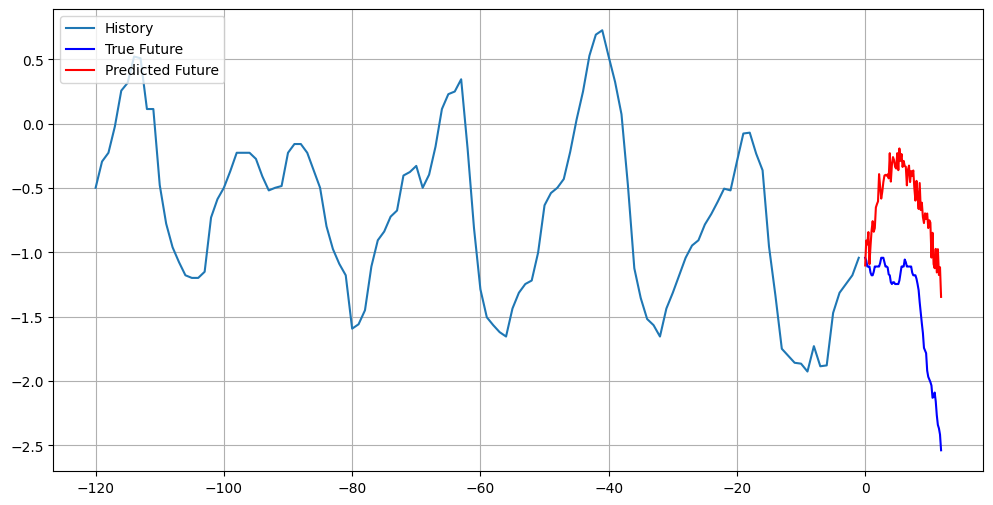

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


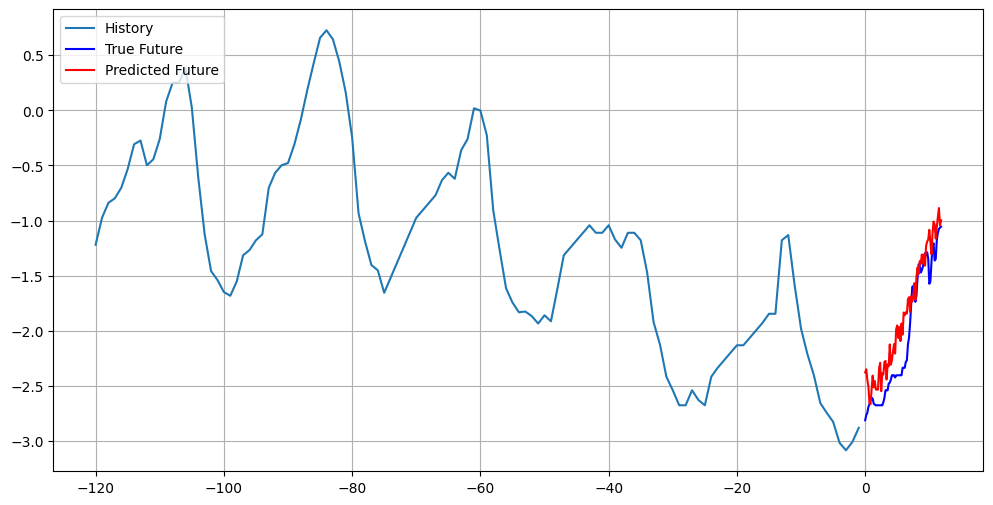

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


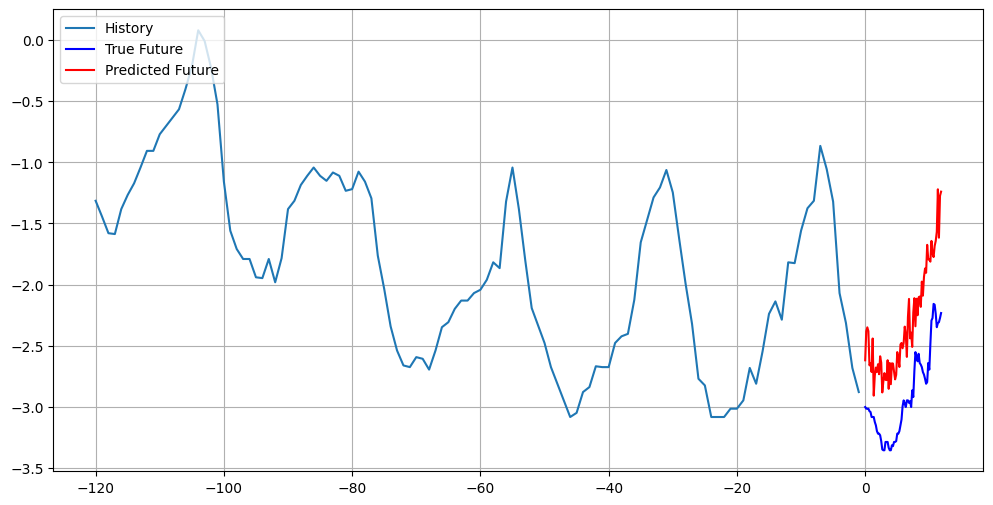

2024-06-03 09:20:02.130384: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [37]:
for x, y in val_data_multi.take(5):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])

In [38]:
directory = '/Users/faymajidelhassan/Downloads/Master project /CODE/EDA/Saved_models'
filename = 'Lstm_multi_step_model_measure+precip.h5'
model_path = f'{directory}/{filename}'
multi_step_model.save(model_path)

In [40]:
import xgboost as xgb

# Define and train XGBoost model

# Train XGBoost model
model_xgb = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
model_xgb.fit(x_train_multi.reshape(x_train_multi.shape[0], -1), y_train_multi[:, -1])  # Using the last value of the future target for training


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [41]:
# Evaluate LSTM model
mae_lstm_single = single_step_model.evaluate(val_ss, steps=100)
mae_lstm_multi=multi_step_model.evaluate(val_data_multi, steps=100)


# Evaluate XGBoost model
xgb_forecast = model_xgb.predict(x_val_multi.reshape(x_val_multi.shape[0], -1))
mae_xgb = np.mean(np.abs(xgb_forecast - y_val_multi[:, -1]))

# Calculate MAE for SARIMAX model
# mae_sarimax = np.mean(np.abs(sarimax_forecast - df['temperature'][train_split:]))

print(f"MAE for single LSTM: {mae_lstm_single}")
print(f"MAE for LSTM: {mae_lstm_multi}")
print(f"MAE for XGBoost: {mae_xgb}")
# print(f"MAE for SARIMAX: {mae_sarimax}")


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 0.5405
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.4335
MAE for single LSTM: 0.5246385335922241
MAE for LSTM: 0.4214077293872833
MAE for XGBoost: 0.7223789099947907


In [ ]:
def plot_forecast(true_values, lstm_pred, xgb_pred, ensemble_pred):
    plt.figure(figsize=(12, 6))
    plt.plot(true_values, label='True Values')
    plt.plot(lstm_pred, label='LSTM Predictions')
    plt.plot(xgb_pred, label='XGBoost Predictions')
    plt.plot(ensemble_pred, label='Ensemble Predictions', linestyle='--')
    plt.legend()
    plt.show()

In [ ]:
import numpy as np

# Example data
true_values = np.random.rand(100)
# lstm_pred = np.random.rand(100)
# xgb_pred = np.random.rand(100)
ensemble_pred = np.random.rand(100)

# Plot the forecasts
plot_forecast(true_values, lstm_pred, xgb_pred, ensemble_pred)


In [52]:
# Define parameters
from sklearn.preprocessing import StandardScaler
# history = 720
# future_target = 72
# STEP = 6
# BATCH_SIZE = 128
# BUFFER_SIZE = 10000
# EPOCHS = 10
# steps_per_epoch = 200
# train_split = int(len(dataset) * 0.7)

# # Fit StandardScaler on training data
# scaler = StandardScaler()
# scaler.fit(dataset[:train_split])

# # Transform the entire dataset
dataset_scaled = dataset

# Function to create multivariate data
def multivariate_data(dataset, target, start_index, end_index, history_size, target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i - history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i + target_size])
        else:
            labels.append(target[i:i + target_size])

    return np.array(data), np.array(labels)

# Create the multivariate data with the scaled dataset
x_train_ss, y_train_ss = multivariate_data(dataset_scaled, dataset_scaled[:, 1], 0, train_split, history, future_target, STEP, single_step=True)
x_val_ss, y_val_ss = multivariate_data(dataset_scaled, dataset_scaled[:, 1], train_split, None, history, future_target, STEP, single_step=True)

# Check shapes
print(x_train_ss.shape, y_train_ss.shape)
print(x_val_ss.shape, y_val_ss.shape)

# Define the dataset for training and validation
train_ss = tf.data.Dataset.from_tensor_slices((x_train_ss, y_train_ss))
val_ss = tf.data.Dataset.from_tensor_slices((x_val_ss, y_val_ss))

# Batch the datasets
train_ss = train_ss.cache().shuffle(buffer_size).batch(batch_size).repeat()
val_ss = val_ss.batch(batch_size).repeat()


(204361, 120, 7) (204361,)
(50479, 120, 7) (50479,)


In [56]:
# Define the GRU model
def create_gru_model(input_shape):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=input_shape),
        tf.keras.layers.GRU(32,return_sequences=True),
        tf.keras.layers.GRU(16,activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mae')
    return model

# Assume x_train_ss.shape is (num_samples, time_steps, features)
input_shape = input_shape=x_train_multi.shape[-2:]
gru_model = create_gru_model(input_shape)

# Train the GRU model
gru_model_history = gru_model.fit(train_ss, epochs=EPOCHS, steps_per_epoch=steps, validation_data=val_ss, validation_steps=50)

# Evaluate GRU model
mae_gru_single = gru_model.evaluate(val_ss, steps=100)
print("Mean Absolute Error for GRU model:", mae_gru_single)


Epoch 1/10


200/200 ━━━━━━━━━━━━━━━━━━━━ 24s 108ms/step - loss: 0.4910 - val_loss: 0.9518
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 21s 103ms/step - loss: 0.5063 - val_loss: 0.5368
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 21s 104ms/step - loss: 0.4973 - val_loss: 0.5628
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 21s 104ms/step - loss: 0.4549 - val_loss: 0.3463
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 20s 101ms/step - loss: 0.4389 - val_loss: 0.5998
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 21s 105ms/step - loss: 0.4547 - val_loss: 0.5124
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 21s 107ms/step - loss: 0.4655 - val_loss: 0.5558
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 21s 104ms/step - loss: 0.4381 - val_loss: 0.3618
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - loss: 0.4298 - val_loss: 0.5616
Epoch 10/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 21s 105ms/step - loss: 0.4416 - val_loss: 0.5400
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.5076
Mean Absolute Error for GRU model: 0.5227797031402588


In [44]:
from tensorflow.keras.layers import LayerNormalization, MultiHeadAttention, Dense, Dropout, Flatten, Input
import tensorflow as tf

# Transformer Block for time series forecasting
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"), 
            Dense(embed_dim),
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs, training=training)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1, training=training)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# Build Transformer model
def build_transformer_model(input_shape, embed_dim):
    inputs = Input(shape=input_shape)
    # Add a Dense layer to project input to the embedding dimension
    x = Dense(embed_dim)(inputs)
    x = TransformerBlock(embed_dim=embed_dim, num_heads=2, ff_dim=32)(x)
    x = Flatten()(x)
    x = Dense(20, activation="relu")(x)
    outputs = Dense(1)(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model


# Build and compile Transformer model
input_shape = x_train_multi.shape[-2:]  # Correct input shape
embed_dim = 32  # Embedding dimension
transformer_model = build_transformer_model(input_shape, embed_dim)
transformer_model.compile(optimizer='adam', loss='mae')

# Train Transformer model
transformer_model_history = transformer_model.fit(train_ss, epochs=EPOCHS, steps_per_epoch=steps,
                                                  validation_data=val_ss, validation_steps=50)

# Evaluate Transformer model
mae_transformer_single = transformer_model.evaluate(val_ss, steps=100)
print("Mean Absolute Error for Transformer model:", mae_transformer_single)



Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 25s 111ms/step - loss: 0.6203 - val_loss: 1.6029
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 22s 112ms/step - loss: 0.4714 - val_loss: 0.6434
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 22s 112ms/step - loss: 0.4629 - val_loss: 0.5578
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 23s 116ms/step - loss: 0.4384 - val_loss: 0.4344
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 22s 111ms/step - loss: 0.4198 - val_loss: 0.5753
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 23s 115ms/step - loss: 0.4364 - val_loss: 0.5623
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 24s 118ms/step - loss: 0.4326 - val_loss: 0.5574
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 22s 110ms/step - loss: 0.4101 - val_loss: 0.4447
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 23s 115ms/step - loss: 0.4052 - val_loss: 0.6245
Epoch 10/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 23s 113ms/step - loss: 0.4169 - val_loss: 0.5803
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 0.5877
Mean Absolute Error for Transformer model: 0.5828633

In [ ]:
import matplotlib.pyplot as plt

def plot_time_series(data, title):
    plt.figure(figsize=(10, 6))
    time_steps = range(len(data[0]))  # History length
    plt.plot(time_steps, data[0], label='History')  # Plot the historical data
    plt.plot(len(data[0]), data[1], 'bo', label='True Future')  # Plot the true future value as a single point
    plt.plot(len(data[0]), data[2], 'ro', label='Predicted Future')  # Plot the predicted future value as a single point
    plt.title(title)
    plt.legend()
    return plt

# Plotting function for Transformer predictions
for x, y in val_ss.take(5):
    prediction = transformer_model.predict(x)
    plot = plot_time_series([x[0].numpy(), y[0].numpy(), prediction[0]], 'Transformer UNIVARIATE')
    plot.show()


In [45]:
# Evaluate GRU model
mae_gru_single = gru_model.evaluate(val_ss, steps=100)
print(f"MAE for GRU: {mae_gru_single}")

# Evaluate Transformer model
mae_transformer_single = transformer_model.evaluate(val_ss, steps=100)
print(f"MAE for Transformer: {mae_transformer_single}")


# Generate predictions for each model
pred_multi_step = multi_step_model.predict(val_data_multi, steps=100)[:, 0]
pred_xgb = model_xgb.predict(x_val_multi.reshape(x_val_multi.shape[0], -1))
pred_gru = gru_model.predict(val_ss, steps=100)[:, 0]
pred_transformer = transformer_model.predict(val_ss, steps=100)[:, 0]

# Check for NaNs in predictions
print("NaNs in pred_multi_step:", np.isnan(pred_multi_step).sum())
print("NaNs in pred_xgb:", np.isnan(pred_xgb).sum())
print("NaNs in pred_gru:", np.isnan(pred_gru).sum())
print("NaNs in pred_transformer:", np.isnan(pred_transformer).sum())

# Ensure all predictions have the same length
# Ensure all predictions have the same length
min_length = min(len(pred_multi_step), len(pred_xgb), len(pred_gru), len(pred_transformer))

pred_multi_step = pred_multi_step[:min_length]
pred_xgb = pred_xgb[:min_length]
pred_gru = pred_gru[:min_length]
pred_transformer = pred_transformer[:min_length]

# Combine predictions from all models
combined_forecast = (pred_multi_step + pred_xgb + pred_gru + pred_transformer) / 4

# Check for NaNs in combined forecast
print("NaNs in combined_forecast:", np.isnan(combined_forecast).sum())
# Ensure true values have the same length as combined_forecast
true_values = dataset_scaled[temperature][train_split:train_split + min_length]

# Check for NaNs in true values
print("NaNs in true_values:", np.isnan(true_values).sum())


# Calculate MAE for ensemble model
# true_values = df['temperature'][train_split:train_split + min_length].values
# Remove NaNs from combined forecast and true values
# Remove NaNs from combined forecast and true values
if np.isnan(combined_forecast).sum() > 0 or np.isnan(true_values).sum() > 0:
    valid_indices = ~np.isnan(combined_forecast) & ~np.isnan(true_values)
    combined_forecast = combined_forecast[valid_indices]
    true_values = true_values[valid_indices]

# Calculate MAE for each feature separately
mae_ensemble = np.mean(np.abs(combined_forecast - true_values), axis=0)

# Print MAE for each feature
for i, mae in enumerate(mae_ensemble):
    print(f"MAE for {features_6[i]}: {mae}")

# Optionally, you can calculate the overall MAE by averaging the MAE for all features
overall_mae_ensemble = np.mean(mae_ensemble)
print(f"Overall MAE for Ensemble Model: {overall_mae_ensemble}")



100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.5203
MAE for GRU: 0.5218005776405334
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 0.5877
MAE for Transformer: 0.5828633308410645
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step
NaNs in pred_multi_step: 0
NaNs in pred_xgb: 0
NaNs in pred_gru: 0
NaNs in pred_transformer: 0
NaNs in combined_forecast: 0


NameError: name 'temperature' is not defined

In [57]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0]
}

# Initialize the model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

# Perform Randomized Search
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_grid, n_iter=50, cv=3, verbose=1, n_jobs=-1)
random_search.fit(x_train_multi.reshape(x_train_multi.shape[0], -1), y_train_multi[:, -1])

# Best parameters
best_params = random_search.best_params_
print(f"Best parameters: {best_params}")


Fitting 3 folds for each of 50 candidates, totalling 150 fits


KeyboardInterrupt: 

In [58]:
# Function to evaluate model on test data
def evaluate_model(model, x_test, y_test):
    predictions = model.predict(x_test)
    mae = np.mean(np.abs(predictions - y_test))
    rmse = np.sqrt(np.mean((predictions - y_test)**2))
    return mae, rmse

# Evaluate models
mae_lstm, rmse_lstm = evaluate_model(lstm_model, x_val_uni, y_val_uni)
mae_gru, rmse_gru = evaluate_model(gru_model, x_val_ss, y_val_ss)
mae_transformer, rmse_transformer = evaluate_model(transformer_model, x_val_ss, y_val_ss)
mae_xgb, rmse_xgb = evaluate_model(model_xgb, x_val_multi.reshape(x_val_multi.shape[0], -1), y_val_multi[:, -1])

print(f"LSTM MAE: {mae_lstm}, RMSE: {rmse_lstm}")
print(f"GRU MAE: {mae_gru}, RMSE: {rmse_gru}")
print(f"Transformer MAE: {mae_transformer}, RMSE: {rmse_transformer}")
print(f"XGBoost MAE: {mae_xgb}, RMSE: {rmse_xgb}")


1602/1602 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


: 

In [ ]:
from sklearn.ensemble import VotingRegressor

# Create ensemble model
ensemble_model = VotingRegressor(estimators=[
    ('lstm', lstm_model),
    ('gru', gru_model),
    ('transformer', transformer_model),
    ('xgb', model_xgb)
])

# Train ensemble model
ensemble_model.fit(x_train_multi.reshape(x_train_multi.shape[0], -1), y_train_multi[:, -1])

# Evaluate ensemble model
mae_ensemble, rmse_ensemble = evaluate_model(ensemble_model, x_val_multi.reshape(x_val_multi.shape[0], -1), y_val_multi[:, -1])
print(f"Ensemble MAE: {mae_ensemble}, RMSE: {rmse_ensemble}")


In [ ]:
def plot_forecast(true_values, lstm_pred, gru_pred, transformer_pred, xgb_pred, ensemble_pred):
    plt.figure(figsize=(12, 6))
    plt.plot(true_values, label='True Values')
    plt.plot(lstm_pred, label='LSTM Predictions')
    plt.plot(gru_pred, label='GRU Predictions')
    plt.plot(transformer_pred, label='Transformer Predictions')
    plt.plot(xgb_pred, label='XGBoost Predictions')
    plt.plot(ensemble_pred, label='Ensemble Predictions', linestyle='--')
    plt.legend()
    plt.show()

# Generate predictions for visualization
true_values = y_val_multi[:, -1]
lstm_pred = lstm_model.predict(x_val_multi[:, -1])
gru_pred = gru_model.predict(x_val_ss, steps=100)[:, 0]
transformer_pred = transformer_model.predict(x_val_ss, steps=100)[:, 0]
xgb_pred = model_xgb.predict(x_val_multi.reshape(x_val_multi.shape[0], -1))
ensemble_pred = ensemble_model.predict(x_val_multi.reshape(x_val_multi.shape[0], -1))

# Plot the forecasts
plot_forecast(true_values, lstm_pred, gru_pred, transformer_pred, xgb_pred, ensemble_pred)
